In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import argparse, os, gzip, torch, time, pickle
import torch.nn as nn
import torch.optim as optim
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [0]:
def dataloader(dataset, input_size, batch_size, split = 'train'):
  
  transform = transforms.Compose([##transforms.Resize((input_size, input_size)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
#                                   transforms.Normalize(mean = (0.5, 0.5, 0.5),
#                                                        std = (0.5, 0.5, 0.5))
  ])
  
  if dataset == 'mnist':
    data_loader = DataLoader(
        datasets.MNIST('data/mnist', train = True, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
  
  elif dataset == 'fashion-mnist':
    data_loader = DataLoader(
        datasets.FashionMNIST('data/fashion-mnist', train = True, download = True,
                              transform = transform),
        batch_size = batch_size, 
        shuffle = True
    )
    
  elif dataset == 'cifar10':
    data_loader = DataLoader(
        datasets.CIFAR10('data/cifar10', train = True, download = True,
                         transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'svhn':
    data_loader = DataLoader(
        datasets.SVHN('data/svhn', split = split, download = True,
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'stl10':
    data_loader = DataLoader(
        datasets.STL10('data/stl10', split = split, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'lsun-bed':
    data_loader = DataLoader(
        datasets.LSUN('data/lsun', classes = ['bedroom_train'],
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  return data_loader

In [0]:
def load_mnist(dataset):
  data_dir = os.path.join("./data", dataset)
  
  def extract_data(filename, num_data, head_size, data_size):
    with gzip.open(filename) as bytestream:
      bytestream.read(head_size)
      buf = bytestream.read(data_size * num_data)
      data = np.frombuffer(buf, dtype = np.uint8).astype(np.float)
    return data
  
  data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
  trX = data.reshape((60000, 28, 28, 1))
  
  data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
  trY = data.reshape((60000))
  
  data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
  teX = data.reshape((10000, 28, 28, 1))
  
  data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
  teY = data.reshape((10000))
  
  trY = np.asarray(trY).astype(np.int)
  teY = np.asarray(teY)
  
  X = np.concatenate((trX, teX), axis = 0)
  y = np.concatenate((trY, teY), axis = 0).astype(np.int)
  
  seed = 547
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(y)
  
  y_vec = np.zeros((len(y), 10), dtype = np.float)
  for i, label in enumerate(y):
    y_vec[i, y[i]] = 1
    
  
  X = X.transpose(0, 3, 1, 2) / 255.
  ## y_vec = y_vec.transpose(0, 3, 1, 2)
  
  
  X = torch.from_numpy(X).type(torch.FloatTensor)
  y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
  return X, y_vec
  

In [0]:
def load_celebA(dir, transform, batch_size, shuffle):
  
  
##    transform = transforms.Compose([
##       transforms.CenterCrop(160),
##       transforms.Scale(64),
##       transforms.ToTensor(),
##       transform.Normalize(mean = (0.5, 0.5, 0.5),
##                           std = (0.5, 0.5, 0.5))
##    ])

##    data_dir = 'data/celebA'    ## this path depends on your computer
  
  dset = datasets.ImageFolder(dir, transform)
  data_loader = torch.utils.data.DataLoader(dset, batch_size, shuffle)
  
  return data_loader

In [0]:
def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)

In [0]:
def save_images(images, size, image_path):
  return imsave(images, size, image_path)

def imsave(images, size, path):
  image = np.squeeze(merge(images, size))
#   image = image.astype(np.uint8)
  return imageio.imwrite(path, image)

In [0]:
def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  
  if(images.shape[3] in (3, 4)):
    c = images.shape[3]
    img = np.zeros((h * size[0], w * size[1], c))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w, :] = image
    return img
  
  elif images.shape[3] == 1:
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w] = image[:, :, 0]
    return img
  
  else:
    raise ValueError('in merge(images, size) images parameter must have dimensions: HxW or HxWx3 or HxWx4')

In [0]:
def generate_animation(path, num):
  images = []
  for e in range(num):
    img_name = path + '_epoch%03d' % (e + 1) + '.png'
    images.append(imageio.imread(img_name))
  imageio.mimsave(path + '_generate_animation.gif', images, fps = 5)

In [0]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
  
  x = range(len(hist['D_loss']))
  
  y1 = hist['D_loss']
  y2 = hist['G_loss']
  
  plt.plot(x, y1, label = 'D_loss')
  plt.plot(x, y2, label = 'G_loss')
  
  plt.xlabel('Iter')
  plt.ylabel('Loss')
  
  plt.legend(loc = 4)
  plt.grid(True)
  plt.tight_layout()
  
  path = os.path.join(path, model_name + '_loss.png')
  
  plt.savefig(path)
  
  plt.close()

In [0]:
def initialize_weights(net):
  
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()

In [0]:
class generator(nn.Module):
  
  ## Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
  
  def __init__(self, input_dim = 100, output_dim = 1, input_size = 32):
    super(generator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.ReLU(),
    )
    
    self.deconv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
        nn.Tanh(),
    )
    
    initialize_weights(self)
    
  
  def forward(self, input):
    x = self.fc(input)
    x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
    x = self.deconv(x)
    return x

In [0]:
class discriminator(nn.Module):
  
  ## Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
  
  def __init__(self, input_dim = 1, output_dim = 1, input_size = 32):
    super(discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.conv = nn.Sequential(
        nn.Conv2d(self.input_dim, 64, 4, 2, 1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
    )
    
    self.fc = nn.Sequential(
        nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Sigmoid(),
    )
    
    initialize_weights(self)
    
  
  def forward(self, input):
    x = self.conv(input)
    x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
    x = self.fc(x)
    return x

In [0]:
class GAN(object):
  
  def __init__(self):
    ## parameters
    self.epoch = 50
    self.sample_num = 100
    self.batch_size = 64
    self.save_dir = 'models'
    self.result_dir = 'results'
    self.dataset = 'mnist'
    self.log_dir = 'logs'
    self.gpu_mode = True
    self.model_name = 'GAN'
    self.input_size = 28
    self.z_dim = 62
    
    
    ## load dataset
    self.data_loader = dataloader(self.dataset, 
                                  self.input_size,
                                  self.batch_size)
    data = self.data_loader.__iter__().__next__()[0]
    
    
    ## networks init
    self.G = generator(input_dim = self.z_dim,
                       output_dim = data.shape[1],
                       input_size = self.input_size)
    self.D = discriminator(input_dim = data.shape[1],
                           output_dim = 1,
                           input_size = self.input_size)
    self.G_optimizer = optim.Adam(self.G.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    self.D_optimizer = optim.Adam(self.D.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.BCE_loss = nn.BCELoss().cuda()
    else:
      self.BCE_loss = nn.BCELoss()
      
    
    print('----------Networks architecture-----------')
    print_network(self.G)
    print_network(self.D)
    print('------------------------------------------')
    
    
    ## fixed noise
    self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
    if self.gpu_mode:
      self.sample_z_ = self.sample_z_.cuda()
      
      
  def train(self):
    self.train_hist = {}
    self.train_hist['D_loss'] = []
    self.train_hist['G_loss'] = []
    self.train_hist['per_epoch_time'] = []
    self.train_hist['total_time'] = []
    
    self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
    if self.gpu_mode:
      self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()
      
    self.D.train()
    print('training start !')
    start_time = time.time()
    for epoch in range(self.epoch):
      self.G.train()
      epoch_start_time = time.time()
      for iter, (x_, _) in enumerate(self.data_loader):
        if iter == self.data_loader.dataset.__len__() // self.batch_size:
          break
          
        z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
          x_, z_ = x_.cuda(), z_.cuda()
          
        
        ## Update D network
        self.D_optimizer.zero_grad()
        
        D_real = self.D(x_)
        D_real_loss = self.BCE_loss(D_real, self.y_real_)
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
        
        D_loss = D_real_loss + D_fake_loss
        self.train_hist['D_loss'].append(D_loss.item())
        
        D_loss.backward()
        self.D_optimizer.step()
        
        
        ## Update G network
        self.G_optimizer.zero_grad()
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        G_loss = self.BCE_loss(D_fake, self.y_real_)
        self.train_hist['G_loss'].append(G_loss.item())
        
        G_loss.backward()
        self.G_optimizer.step()
        
        
        if ((iter + 1) % 100) == 0:
          print("Epoch: [%2d] [%4d / %4d] D_loss: %.8f, G_loss: %.8f" %
                ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size,
                 D_loss.item(), G_loss.item()))
          
      self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
      with torch.no_grad():
        self.visualize_results((epoch + 1))
        
    self.train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
                                                                   self.epoch, self.train_hist['total_time'][0]))
    print("Training finish! Saved training results")
    
    self.save()
    
    generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                       self.epoch)
    loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
    
    
  def visualize_results(self, epoch, fix = True):
    self.G.eval()
    
    if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
      os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)
      
    tot_num_samples = min(self.sample_num, self.batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
    
    if fix:
      """ fixed noise """
      samples = self.G(self.sample_z_)
      
    else:
      """ random noise """
      sample_z_ = torch.rand((self.batch_size, self.z_dim))
      if self.gpu_mode:
        sample_z_ = sample_z_.cuda()
        
      samples = self.G(sample_z_)
      
    
    if self.gpu_mode:
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    else:
      samples = samples.data.numpy().transpose(0, 2, 3, 1)
      
    
    samples = (samples + 1) / 2
    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :],
                [image_frame_dim, image_frame_dim],
                self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
    
  def save(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
      
    torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
    torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))
    
    with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
      pickle.dump(self.train_hist, f)
      
      
  def load(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
    self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [14]:
def main():
  
  gan = GAN()
  
  gan.train()
  print(" [**] Training finished!")
  
  ## visualize learned generator
  gan.visualize_results(50)
  print(" [**] Testing finished!")
  
if __name__ == '__main__':
  main()

----------Networks architecture-----------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6640193
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 

Epoch: [ 2] [ 100 /  937] D_loss: 1.00040114, G_loss: 1.08457923
Epoch: [ 2] [ 200 /  937] D_loss: 1.02970088, G_loss: 1.17682827
Epoch: [ 2] [ 300 /  937] D_loss: 0.98709643, G_loss: 1.05151987
Epoch: [ 2] [ 400 /  937] D_loss: 1.01835787, G_loss: 1.09287238
Epoch: [ 2] [ 500 /  937] D_loss: 0.99295622, G_loss: 1.30228043
Epoch: [ 2] [ 600 /  937] D_loss: 1.04077899, G_loss: 1.05960417
Epoch: [ 2] [ 700 /  937] D_loss: 1.09756660, G_loss: 1.14325285
Epoch: [ 2] [ 800 /  937] D_loss: 1.10267305, G_loss: 1.07789838
Epoch: [ 2] [ 900 /  937] D_loss: 1.12729669, G_loss: 1.03529644


Epoch: [ 3] [ 100 /  937] D_loss: 1.07780492, G_loss: 1.04296279
Epoch: [ 3] [ 200 /  937] D_loss: 0.86253798, G_loss: 1.28846288
Epoch: [ 3] [ 300 /  937] D_loss: 0.98379999, G_loss: 1.20105839
Epoch: [ 3] [ 400 /  937] D_loss: 0.95475948, G_loss: 1.20663226
Epoch: [ 3] [ 500 /  937] D_loss: 0.98817456, G_loss: 1.12071729
Epoch: [ 3] [ 600 /  937] D_loss: 1.02799356, G_loss: 1.11553395
Epoch: [ 3] [ 700 /  937] D_loss: 0.98936462, G_loss: 1.14447653
Epoch: [ 3] [ 800 /  937] D_loss: 0.98719621, G_loss: 1.35709071
Epoch: [ 3] [ 900 /  937] D_loss: 0.91925263, G_loss: 1.31595874


Epoch: [ 4] [ 100 /  937] D_loss: 0.97542441, G_loss: 0.93076110
Epoch: [ 4] [ 200 /  937] D_loss: 0.97875333, G_loss: 1.29332733
Epoch: [ 4] [ 300 /  937] D_loss: 0.93100488, G_loss: 1.41517735
Epoch: [ 4] [ 400 /  937] D_loss: 0.91252172, G_loss: 1.25305641
Epoch: [ 4] [ 500 /  937] D_loss: 0.91826332, G_loss: 1.29233909
Epoch: [ 4] [ 600 /  937] D_loss: 0.89857984, G_loss: 1.15714455
Epoch: [ 4] [ 700 /  937] D_loss: 0.97727644, G_loss: 1.01497662
Epoch: [ 4] [ 800 /  937] D_loss: 0.87613606, G_loss: 1.32360005
Epoch: [ 4] [ 900 /  937] D_loss: 1.02312446, G_loss: 1.30268264


Epoch: [ 5] [ 100 /  937] D_loss: 0.88367790, G_loss: 1.40301490
Epoch: [ 5] [ 200 /  937] D_loss: 1.00191069, G_loss: 1.26646161
Epoch: [ 5] [ 300 /  937] D_loss: 0.98731399, G_loss: 1.54638815
Epoch: [ 5] [ 400 /  937] D_loss: 0.93603790, G_loss: 1.44865477
Epoch: [ 5] [ 500 /  937] D_loss: 0.79572678, G_loss: 1.28447294
Epoch: [ 5] [ 600 /  937] D_loss: 0.89749694, G_loss: 1.27260232
Epoch: [ 5] [ 700 /  937] D_loss: 0.81858695, G_loss: 1.52023196
Epoch: [ 5] [ 800 /  937] D_loss: 0.87859941, G_loss: 1.48939812
Epoch: [ 5] [ 900 /  937] D_loss: 1.16169095, G_loss: 1.27946806


Epoch: [ 6] [ 100 /  937] D_loss: 0.80930948, G_loss: 1.33960009
Epoch: [ 6] [ 200 /  937] D_loss: 0.83765918, G_loss: 1.37574446
Epoch: [ 6] [ 300 /  937] D_loss: 0.77016836, G_loss: 1.44278121
Epoch: [ 6] [ 400 /  937] D_loss: 0.76770514, G_loss: 1.32386446
Epoch: [ 6] [ 500 /  937] D_loss: 0.81902516, G_loss: 1.62931776
Epoch: [ 6] [ 600 /  937] D_loss: 0.75455749, G_loss: 1.43535388
Epoch: [ 6] [ 700 /  937] D_loss: 0.66781360, G_loss: 1.64453995
Epoch: [ 6] [ 800 /  937] D_loss: 0.79336447, G_loss: 1.59995341
Epoch: [ 6] [ 900 /  937] D_loss: 0.79440510, G_loss: 1.30225909


Epoch: [ 7] [ 100 /  937] D_loss: 0.67435038, G_loss: 1.66639996
Epoch: [ 7] [ 200 /  937] D_loss: 1.15538478, G_loss: 0.76429522
Epoch: [ 7] [ 300 /  937] D_loss: 0.78742814, G_loss: 1.30453885
Epoch: [ 7] [ 400 /  937] D_loss: 0.88699031, G_loss: 1.49437189
Epoch: [ 7] [ 500 /  937] D_loss: 0.61601293, G_loss: 1.99749970
Epoch: [ 7] [ 600 /  937] D_loss: 0.97007298, G_loss: 1.26833463
Epoch: [ 7] [ 700 /  937] D_loss: 0.73546135, G_loss: 1.67161679
Epoch: [ 7] [ 800 /  937] D_loss: 0.71875316, G_loss: 1.81914043
Epoch: [ 7] [ 900 /  937] D_loss: 0.79707301, G_loss: 1.49945831


Epoch: [ 8] [ 100 /  937] D_loss: 0.69875407, G_loss: 1.51853907
Epoch: [ 8] [ 200 /  937] D_loss: 0.72539371, G_loss: 1.53972054
Epoch: [ 8] [ 300 /  937] D_loss: 0.72922349, G_loss: 1.91862535
Epoch: [ 8] [ 400 /  937] D_loss: 0.79558170, G_loss: 1.51162004
Epoch: [ 8] [ 500 /  937] D_loss: 0.76199520, G_loss: 1.47712564
Epoch: [ 8] [ 600 /  937] D_loss: 0.56696182, G_loss: 2.27034140
Epoch: [ 8] [ 700 /  937] D_loss: 0.57816875, G_loss: 1.82729828
Epoch: [ 8] [ 800 /  937] D_loss: 0.90100592, G_loss: 1.04571569
Epoch: [ 8] [ 900 /  937] D_loss: 0.52197802, G_loss: 1.71271944


Epoch: [ 9] [ 100 /  937] D_loss: 0.59231544, G_loss: 1.72256184
Epoch: [ 9] [ 200 /  937] D_loss: 0.88662922, G_loss: 1.29750454
Epoch: [ 9] [ 300 /  937] D_loss: 0.90552771, G_loss: 1.02253413
Epoch: [ 9] [ 400 /  937] D_loss: 0.62699002, G_loss: 1.90419447
Epoch: [ 9] [ 500 /  937] D_loss: 0.68666875, G_loss: 1.48177338
Epoch: [ 9] [ 600 /  937] D_loss: 0.72988689, G_loss: 1.55341077
Epoch: [ 9] [ 700 /  937] D_loss: 0.63898802, G_loss: 1.83017063
Epoch: [ 9] [ 800 /  937] D_loss: 0.70705187, G_loss: 2.04002047
Epoch: [ 9] [ 900 /  937] D_loss: 0.50617909, G_loss: 2.03564405


Epoch: [10] [ 100 /  937] D_loss: 0.70150757, G_loss: 2.05940914
Epoch: [10] [ 200 /  937] D_loss: 0.70259535, G_loss: 1.59340250
Epoch: [10] [ 300 /  937] D_loss: 0.55879229, G_loss: 2.18870878
Epoch: [10] [ 400 /  937] D_loss: 0.60966694, G_loss: 2.60026979
Epoch: [10] [ 500 /  937] D_loss: 0.58742267, G_loss: 2.22584295
Epoch: [10] [ 600 /  937] D_loss: 0.66750145, G_loss: 2.02598929
Epoch: [10] [ 700 /  937] D_loss: 0.57070339, G_loss: 2.36284018
Epoch: [10] [ 800 /  937] D_loss: 0.68061924, G_loss: 2.14590669
Epoch: [10] [ 900 /  937] D_loss: 0.72352362, G_loss: 1.86796188


Epoch: [11] [ 100 /  937] D_loss: 0.65388179, G_loss: 1.40692163
Epoch: [11] [ 200 /  937] D_loss: 0.58286464, G_loss: 1.63106871
Epoch: [11] [ 300 /  937] D_loss: 0.42969567, G_loss: 2.18197060
Epoch: [11] [ 400 /  937] D_loss: 0.74859989, G_loss: 1.21510816
Epoch: [11] [ 500 /  937] D_loss: 0.60448056, G_loss: 2.32995915
Epoch: [11] [ 600 /  937] D_loss: 0.81163037, G_loss: 1.84457171
Epoch: [11] [ 700 /  937] D_loss: 0.93988705, G_loss: 2.37202835
Epoch: [11] [ 800 /  937] D_loss: 0.48554453, G_loss: 1.97398627
Epoch: [11] [ 900 /  937] D_loss: 0.63132554, G_loss: 2.03562236


Epoch: [12] [ 100 /  937] D_loss: 0.41034085, G_loss: 2.31008291
Epoch: [12] [ 200 /  937] D_loss: 0.70075667, G_loss: 2.09716654
Epoch: [12] [ 300 /  937] D_loss: 0.47912705, G_loss: 2.34068704
Epoch: [12] [ 400 /  937] D_loss: 0.60256720, G_loss: 2.14602661
Epoch: [12] [ 500 /  937] D_loss: 0.61497796, G_loss: 1.77141786
Epoch: [12] [ 600 /  937] D_loss: 0.56541073, G_loss: 1.77512181
Epoch: [12] [ 700 /  937] D_loss: 0.52730697, G_loss: 2.22750378
Epoch: [12] [ 800 /  937] D_loss: 0.63523453, G_loss: 2.54598665
Epoch: [12] [ 900 /  937] D_loss: 0.56348848, G_loss: 2.21019912


Epoch: [13] [ 100 /  937] D_loss: 0.54300219, G_loss: 2.10008144
Epoch: [13] [ 200 /  937] D_loss: 0.68199831, G_loss: 1.84761846
Epoch: [13] [ 300 /  937] D_loss: 0.69123489, G_loss: 1.79097605
Epoch: [13] [ 400 /  937] D_loss: 0.68625355, G_loss: 1.53554404
Epoch: [13] [ 500 /  937] D_loss: 0.51992083, G_loss: 2.74456382
Epoch: [13] [ 600 /  937] D_loss: 0.81857538, G_loss: 1.38575530
Epoch: [13] [ 700 /  937] D_loss: 0.72939581, G_loss: 3.08509994
Epoch: [13] [ 800 /  937] D_loss: 0.53224993, G_loss: 2.74655390
Epoch: [13] [ 900 /  937] D_loss: 0.40296158, G_loss: 2.78491378


Epoch: [14] [ 100 /  937] D_loss: 0.74483031, G_loss: 2.99154854
Epoch: [14] [ 200 /  937] D_loss: 0.73817086, G_loss: 3.23457527
Epoch: [14] [ 300 /  937] D_loss: 0.39729193, G_loss: 2.59210920
Epoch: [14] [ 400 /  937] D_loss: 0.60026991, G_loss: 2.38661432
Epoch: [14] [ 500 /  937] D_loss: 0.50712168, G_loss: 1.93669093
Epoch: [14] [ 600 /  937] D_loss: 0.50034183, G_loss: 2.08848310
Epoch: [14] [ 700 /  937] D_loss: 0.64660084, G_loss: 1.65660787
Epoch: [14] [ 800 /  937] D_loss: 0.67474771, G_loss: 2.57451224
Epoch: [14] [ 900 /  937] D_loss: 0.45542687, G_loss: 2.69122362


Epoch: [15] [ 100 /  937] D_loss: 0.67384964, G_loss: 1.95879948
Epoch: [15] [ 200 /  937] D_loss: 0.37777039, G_loss: 2.60466766
Epoch: [15] [ 300 /  937] D_loss: 0.54795074, G_loss: 2.79670858
Epoch: [15] [ 400 /  937] D_loss: 0.71560681, G_loss: 2.16832304
Epoch: [15] [ 500 /  937] D_loss: 0.65224946, G_loss: 2.36670184
Epoch: [15] [ 600 /  937] D_loss: 0.48496658, G_loss: 2.58629179
Epoch: [15] [ 700 /  937] D_loss: 0.55291766, G_loss: 1.92948902
Epoch: [15] [ 800 /  937] D_loss: 0.49193409, G_loss: 2.55416536
Epoch: [15] [ 900 /  937] D_loss: 0.61179101, G_loss: 2.39130449


Epoch: [16] [ 100 /  937] D_loss: 0.50139421, G_loss: 2.30468702
Epoch: [16] [ 200 /  937] D_loss: 0.63842660, G_loss: 3.73237133
Epoch: [16] [ 300 /  937] D_loss: 0.51575410, G_loss: 1.83722842
Epoch: [16] [ 400 /  937] D_loss: 0.66052735, G_loss: 2.42867517
Epoch: [16] [ 500 /  937] D_loss: 0.50218952, G_loss: 2.59697771
Epoch: [16] [ 600 /  937] D_loss: 0.55186272, G_loss: 1.69780469
Epoch: [16] [ 700 /  937] D_loss: 0.42150146, G_loss: 2.13490081
Epoch: [16] [ 800 /  937] D_loss: 0.45884120, G_loss: 2.35829926
Epoch: [16] [ 900 /  937] D_loss: 0.53462267, G_loss: 2.65656424


Epoch: [17] [ 100 /  937] D_loss: 0.41253421, G_loss: 2.58423710
Epoch: [17] [ 200 /  937] D_loss: 0.45625705, G_loss: 1.96667516
Epoch: [17] [ 300 /  937] D_loss: 0.42632908, G_loss: 2.79047012
Epoch: [17] [ 400 /  937] D_loss: 0.39294553, G_loss: 2.74770904
Epoch: [17] [ 500 /  937] D_loss: 0.54356444, G_loss: 2.17857718
Epoch: [17] [ 600 /  937] D_loss: 0.35623935, G_loss: 2.41935873
Epoch: [17] [ 700 /  937] D_loss: 0.34824461, G_loss: 2.27307463
Epoch: [17] [ 800 /  937] D_loss: 0.37314156, G_loss: 3.12792611
Epoch: [17] [ 900 /  937] D_loss: 0.39671382, G_loss: 3.26720190


Epoch: [18] [ 100 /  937] D_loss: 0.65750921, G_loss: 1.60307479
Epoch: [18] [ 200 /  937] D_loss: 0.55110431, G_loss: 2.50588608
Epoch: [18] [ 300 /  937] D_loss: 0.74389791, G_loss: 1.48738849
Epoch: [18] [ 400 /  937] D_loss: 0.29961437, G_loss: 2.78526902
Epoch: [18] [ 500 /  937] D_loss: 0.64493406, G_loss: 1.93760800
Epoch: [18] [ 600 /  937] D_loss: 0.45603907, G_loss: 2.63506150
Epoch: [18] [ 700 /  937] D_loss: 0.47007522, G_loss: 2.88828468
Epoch: [18] [ 800 /  937] D_loss: 0.47972345, G_loss: 1.91120458
Epoch: [18] [ 900 /  937] D_loss: 0.20860347, G_loss: 2.83621454


Epoch: [19] [ 100 /  937] D_loss: 0.32786146, G_loss: 3.30743527
Epoch: [19] [ 200 /  937] D_loss: 0.34350032, G_loss: 2.80081582
Epoch: [19] [ 300 /  937] D_loss: 0.35309374, G_loss: 2.57021523
Epoch: [19] [ 400 /  937] D_loss: 0.53780019, G_loss: 1.84051561
Epoch: [19] [ 500 /  937] D_loss: 0.46451539, G_loss: 2.99903965
Epoch: [19] [ 600 /  937] D_loss: 0.50522816, G_loss: 2.47688675
Epoch: [19] [ 700 /  937] D_loss: 0.40747926, G_loss: 2.41224146
Epoch: [19] [ 800 /  937] D_loss: 0.79182559, G_loss: 2.82670259
Epoch: [19] [ 900 /  937] D_loss: 0.30549428, G_loss: 2.87097979


Epoch: [20] [ 100 /  937] D_loss: 0.35907248, G_loss: 2.70115852
Epoch: [20] [ 200 /  937] D_loss: 0.23994042, G_loss: 3.05457520
Epoch: [20] [ 300 /  937] D_loss: 0.40409410, G_loss: 2.88960171
Epoch: [20] [ 400 /  937] D_loss: 0.68595791, G_loss: 2.64615464
Epoch: [20] [ 500 /  937] D_loss: 0.62969387, G_loss: 2.50900245
Epoch: [20] [ 600 /  937] D_loss: 0.48341841, G_loss: 3.19199371
Epoch: [20] [ 700 /  937] D_loss: 0.23138177, G_loss: 3.36818194
Epoch: [20] [ 800 /  937] D_loss: 0.44465587, G_loss: 2.32142019
Epoch: [20] [ 900 /  937] D_loss: 0.62636805, G_loss: 2.33713865


Epoch: [21] [ 100 /  937] D_loss: 0.43111914, G_loss: 3.57847977
Epoch: [21] [ 200 /  937] D_loss: 0.45304772, G_loss: 2.95410156
Epoch: [21] [ 300 /  937] D_loss: 0.37020844, G_loss: 2.59214783
Epoch: [21] [ 400 /  937] D_loss: 0.38245234, G_loss: 2.59810781
Epoch: [21] [ 500 /  937] D_loss: 0.47299647, G_loss: 2.33180046
Epoch: [21] [ 600 /  937] D_loss: 0.35522899, G_loss: 2.30234575
Epoch: [21] [ 700 /  937] D_loss: 0.44603890, G_loss: 2.93044806
Epoch: [21] [ 800 /  937] D_loss: 0.59043545, G_loss: 3.70325708
Epoch: [21] [ 900 /  937] D_loss: 0.31747189, G_loss: 3.12275696


Epoch: [22] [ 100 /  937] D_loss: 0.30835512, G_loss: 2.92312050
Epoch: [22] [ 200 /  937] D_loss: 0.29102537, G_loss: 3.11270094
Epoch: [22] [ 300 /  937] D_loss: 0.31003648, G_loss: 3.12938261
Epoch: [22] [ 400 /  937] D_loss: 0.43795356, G_loss: 2.56895924
Epoch: [22] [ 500 /  937] D_loss: 0.28413087, G_loss: 3.45329833
Epoch: [22] [ 600 /  937] D_loss: 0.59388274, G_loss: 1.86409664
Epoch: [22] [ 700 /  937] D_loss: 0.29474166, G_loss: 3.11365676
Epoch: [22] [ 800 /  937] D_loss: 0.35221377, G_loss: 2.55893040
Epoch: [22] [ 900 /  937] D_loss: 0.26667678, G_loss: 3.27332473


Epoch: [23] [ 100 /  937] D_loss: 0.35269323, G_loss: 3.42293048
Epoch: [23] [ 200 /  937] D_loss: 0.22435501, G_loss: 3.22861290
Epoch: [23] [ 300 /  937] D_loss: 0.27485558, G_loss: 3.15259671
Epoch: [23] [ 400 /  937] D_loss: 0.37590620, G_loss: 3.46220589
Epoch: [23] [ 500 /  937] D_loss: 0.34193259, G_loss: 3.11268258
Epoch: [23] [ 600 /  937] D_loss: 0.40463707, G_loss: 2.40750432
Epoch: [23] [ 700 /  937] D_loss: 0.38107437, G_loss: 2.94033670
Epoch: [23] [ 800 /  937] D_loss: 0.36044937, G_loss: 3.27510595
Epoch: [23] [ 900 /  937] D_loss: 0.35145849, G_loss: 2.58054233


Epoch: [24] [ 100 /  937] D_loss: 0.32075435, G_loss: 2.73242140
Epoch: [24] [ 200 /  937] D_loss: 0.39832380, G_loss: 2.55419731
Epoch: [24] [ 300 /  937] D_loss: 0.30181885, G_loss: 3.53185368
Epoch: [24] [ 400 /  937] D_loss: 0.35024208, G_loss: 2.47897291
Epoch: [24] [ 500 /  937] D_loss: 0.49597302, G_loss: 2.33159113
Epoch: [24] [ 600 /  937] D_loss: 0.53891623, G_loss: 3.95797539
Epoch: [24] [ 700 /  937] D_loss: 0.40194735, G_loss: 3.90881038
Epoch: [24] [ 800 /  937] D_loss: 0.36046261, G_loss: 3.24712086
Epoch: [24] [ 900 /  937] D_loss: 0.29980999, G_loss: 3.02710533


Epoch: [25] [ 100 /  937] D_loss: 0.34813616, G_loss: 2.41838551
Epoch: [25] [ 200 /  937] D_loss: 0.39333373, G_loss: 3.20082235
Epoch: [25] [ 300 /  937] D_loss: 0.46712035, G_loss: 2.54083490
Epoch: [25] [ 400 /  937] D_loss: 0.30296475, G_loss: 3.09830379
Epoch: [25] [ 500 /  937] D_loss: 0.37754774, G_loss: 2.49969053
Epoch: [25] [ 600 /  937] D_loss: 0.71276385, G_loss: 2.71807504
Epoch: [25] [ 700 /  937] D_loss: 0.94723630, G_loss: 2.98869085
Epoch: [25] [ 800 /  937] D_loss: 0.27161235, G_loss: 2.74490619
Epoch: [25] [ 900 /  937] D_loss: 0.31268790, G_loss: 2.79722643


Epoch: [26] [ 100 /  937] D_loss: 0.26457244, G_loss: 2.76545787
Epoch: [26] [ 200 /  937] D_loss: 0.45014983, G_loss: 2.31657696
Epoch: [26] [ 300 /  937] D_loss: 0.52260554, G_loss: 2.18964481
Epoch: [26] [ 400 /  937] D_loss: 0.33479795, G_loss: 3.58032537
Epoch: [26] [ 500 /  937] D_loss: 0.48691565, G_loss: 2.44157791
Epoch: [26] [ 600 /  937] D_loss: 0.31308582, G_loss: 3.65543413
Epoch: [26] [ 700 /  937] D_loss: 0.32821062, G_loss: 2.06673741
Epoch: [26] [ 800 /  937] D_loss: 0.33521694, G_loss: 2.88805628
Epoch: [26] [ 900 /  937] D_loss: 0.45298070, G_loss: 2.39710498


Epoch: [27] [ 100 /  937] D_loss: 0.42053047, G_loss: 4.00800037
Epoch: [27] [ 200 /  937] D_loss: 0.24574722, G_loss: 3.46715975
Epoch: [27] [ 300 /  937] D_loss: 0.42518672, G_loss: 2.38595271
Epoch: [27] [ 400 /  937] D_loss: 0.30398321, G_loss: 3.59905052
Epoch: [27] [ 500 /  937] D_loss: 0.51383442, G_loss: 2.89899874
Epoch: [27] [ 600 /  937] D_loss: 0.27717781, G_loss: 2.82376122
Epoch: [27] [ 700 /  937] D_loss: 0.30817151, G_loss: 2.74006462
Epoch: [27] [ 800 /  937] D_loss: 0.90046477, G_loss: 2.58993483
Epoch: [27] [ 900 /  937] D_loss: 0.36505419, G_loss: 2.75577378


Epoch: [28] [ 100 /  937] D_loss: 0.34262532, G_loss: 4.14964771
Epoch: [28] [ 200 /  937] D_loss: 0.26006430, G_loss: 3.77260876
Epoch: [28] [ 300 /  937] D_loss: 0.79584944, G_loss: 2.18682599
Epoch: [28] [ 400 /  937] D_loss: 0.57345349, G_loss: 2.58674598
Epoch: [28] [ 500 /  937] D_loss: 0.36773884, G_loss: 3.67747974
Epoch: [28] [ 600 /  937] D_loss: 0.20229110, G_loss: 3.26442051
Epoch: [28] [ 700 /  937] D_loss: 0.20894991, G_loss: 3.43766069
Epoch: [28] [ 800 /  937] D_loss: 0.20515573, G_loss: 3.63701224
Epoch: [28] [ 900 /  937] D_loss: 0.35119969, G_loss: 3.54185867


Epoch: [29] [ 100 /  937] D_loss: 0.42529920, G_loss: 3.71082783
Epoch: [29] [ 200 /  937] D_loss: 0.20827061, G_loss: 3.64995933
Epoch: [29] [ 300 /  937] D_loss: 0.29306057, G_loss: 3.02783132
Epoch: [29] [ 400 /  937] D_loss: 0.39806652, G_loss: 3.20131779
Epoch: [29] [ 500 /  937] D_loss: 0.31238300, G_loss: 3.13480139
Epoch: [29] [ 600 /  937] D_loss: 0.53958869, G_loss: 2.24396586
Epoch: [29] [ 700 /  937] D_loss: 0.32852039, G_loss: 2.74852014
Epoch: [29] [ 800 /  937] D_loss: 0.41349548, G_loss: 3.26488686
Epoch: [29] [ 900 /  937] D_loss: 0.15618280, G_loss: 3.72491693


Epoch: [30] [ 100 /  937] D_loss: 0.29795143, G_loss: 3.57883501
Epoch: [30] [ 200 /  937] D_loss: 0.77710217, G_loss: 4.22837067
Epoch: [30] [ 300 /  937] D_loss: 0.22831030, G_loss: 3.18687463
Epoch: [30] [ 400 /  937] D_loss: 0.29892921, G_loss: 3.32425642
Epoch: [30] [ 500 /  937] D_loss: 0.45149595, G_loss: 2.86669159
Epoch: [30] [ 600 /  937] D_loss: 0.25775701, G_loss: 3.18688893
Epoch: [30] [ 700 /  937] D_loss: 0.20266891, G_loss: 3.86753416
Epoch: [30] [ 800 /  937] D_loss: 0.53784847, G_loss: 2.96178102
Epoch: [30] [ 900 /  937] D_loss: 0.36483800, G_loss: 3.53076649


Epoch: [31] [ 100 /  937] D_loss: 0.22192612, G_loss: 3.32957673
Epoch: [31] [ 200 /  937] D_loss: 0.72006184, G_loss: 1.02312469
Epoch: [31] [ 300 /  937] D_loss: 0.49981487, G_loss: 4.05725193
Epoch: [31] [ 400 /  937] D_loss: 0.25423545, G_loss: 3.08696508
Epoch: [31] [ 500 /  937] D_loss: 0.50214177, G_loss: 1.81618154
Epoch: [31] [ 600 /  937] D_loss: 0.27905428, G_loss: 3.69554210
Epoch: [31] [ 700 /  937] D_loss: 0.24579623, G_loss: 3.59481859
Epoch: [31] [ 800 /  937] D_loss: 0.19066535, G_loss: 4.14981937
Epoch: [31] [ 900 /  937] D_loss: 0.35213125, G_loss: 4.15416718


Epoch: [32] [ 100 /  937] D_loss: 0.28414488, G_loss: 2.23984432
Epoch: [32] [ 200 /  937] D_loss: 0.29769936, G_loss: 4.50704813
Epoch: [32] [ 300 /  937] D_loss: 0.42054117, G_loss: 4.28245640
Epoch: [32] [ 400 /  937] D_loss: 0.35944766, G_loss: 2.66583085
Epoch: [32] [ 500 /  937] D_loss: 0.43546131, G_loss: 4.01306200
Epoch: [32] [ 600 /  937] D_loss: 0.34428778, G_loss: 2.99105787
Epoch: [32] [ 700 /  937] D_loss: 0.30316788, G_loss: 2.90150285
Epoch: [32] [ 800 /  937] D_loss: 0.28563833, G_loss: 3.42335701
Epoch: [32] [ 900 /  937] D_loss: 0.31761265, G_loss: 2.28908539


Epoch: [33] [ 100 /  937] D_loss: 0.36558703, G_loss: 2.41956234
Epoch: [33] [ 200 /  937] D_loss: 0.26220086, G_loss: 3.42362070
Epoch: [33] [ 300 /  937] D_loss: 0.18841833, G_loss: 3.70215464
Epoch: [33] [ 400 /  937] D_loss: 0.25234810, G_loss: 3.60013151
Epoch: [33] [ 500 /  937] D_loss: 0.29240698, G_loss: 3.54138517
Epoch: [33] [ 600 /  937] D_loss: 0.30390054, G_loss: 4.70848227
Epoch: [33] [ 700 /  937] D_loss: 0.90769559, G_loss: 3.46316051
Epoch: [33] [ 800 /  937] D_loss: 0.48143861, G_loss: 4.43593407
Epoch: [33] [ 900 /  937] D_loss: 0.27525312, G_loss: 2.49351025


Epoch: [34] [ 100 /  937] D_loss: 0.18439993, G_loss: 3.44569921
Epoch: [34] [ 200 /  937] D_loss: 0.27491510, G_loss: 3.72020769
Epoch: [34] [ 300 /  937] D_loss: 0.29656392, G_loss: 3.87349224
Epoch: [34] [ 400 /  937] D_loss: 0.17097570, G_loss: 3.55386090
Epoch: [34] [ 500 /  937] D_loss: 0.51752836, G_loss: 3.39369035
Epoch: [34] [ 600 /  937] D_loss: 0.19175223, G_loss: 3.69317174
Epoch: [34] [ 700 /  937] D_loss: 0.38184035, G_loss: 3.40291119
Epoch: [34] [ 800 /  937] D_loss: 0.36965802, G_loss: 4.11495304
Epoch: [34] [ 900 /  937] D_loss: 0.47945189, G_loss: 4.61907625


Epoch: [35] [ 100 /  937] D_loss: 0.37620175, G_loss: 4.03313446
Epoch: [35] [ 200 /  937] D_loss: 0.23830593, G_loss: 4.40121937
Epoch: [35] [ 300 /  937] D_loss: 0.22344440, G_loss: 3.69977236
Epoch: [35] [ 400 /  937] D_loss: 0.26796898, G_loss: 3.07616663
Epoch: [35] [ 500 /  937] D_loss: 0.34387434, G_loss: 3.41763186
Epoch: [35] [ 600 /  937] D_loss: 0.31036279, G_loss: 4.73073101
Epoch: [35] [ 700 /  937] D_loss: 0.28132412, G_loss: 2.54971933
Epoch: [35] [ 800 /  937] D_loss: 0.24363625, G_loss: 3.45470929
Epoch: [35] [ 900 /  937] D_loss: 0.25926572, G_loss: 3.98661900


Epoch: [36] [ 100 /  937] D_loss: 0.65699875, G_loss: 3.41554785
Epoch: [36] [ 200 /  937] D_loss: 0.30971712, G_loss: 3.74596143
Epoch: [36] [ 300 /  937] D_loss: 0.32675636, G_loss: 4.20626974
Epoch: [36] [ 400 /  937] D_loss: 0.48359954, G_loss: 4.61816692
Epoch: [36] [ 500 /  937] D_loss: 0.36251780, G_loss: 3.42992139
Epoch: [36] [ 600 /  937] D_loss: 0.38948691, G_loss: 2.65916586
Epoch: [36] [ 700 /  937] D_loss: 0.59024650, G_loss: 4.34658527
Epoch: [36] [ 800 /  937] D_loss: 0.29103622, G_loss: 2.41138506
Epoch: [36] [ 900 /  937] D_loss: 0.23916771, G_loss: 3.04551744


Epoch: [37] [ 100 /  937] D_loss: 0.21064378, G_loss: 4.03365993
Epoch: [37] [ 200 /  937] D_loss: 0.22226626, G_loss: 4.08841038
Epoch: [37] [ 300 /  937] D_loss: 0.18812095, G_loss: 3.87005138
Epoch: [37] [ 400 /  937] D_loss: 0.26754731, G_loss: 3.97796631
Epoch: [37] [ 500 /  937] D_loss: 0.23599069, G_loss: 2.94472837
Epoch: [37] [ 600 /  937] D_loss: 0.18001339, G_loss: 2.97319841
Epoch: [37] [ 700 /  937] D_loss: 0.21813455, G_loss: 3.68563008
Epoch: [37] [ 800 /  937] D_loss: 0.25868982, G_loss: 2.52886462
Epoch: [37] [ 900 /  937] D_loss: 0.52412361, G_loss: 4.03228569


Epoch: [38] [ 100 /  937] D_loss: 0.23626707, G_loss: 3.80860496
Epoch: [38] [ 200 /  937] D_loss: 0.34695822, G_loss: 4.24950218
Epoch: [38] [ 300 /  937] D_loss: 0.25712490, G_loss: 2.79921699
Epoch: [38] [ 400 /  937] D_loss: 0.24513415, G_loss: 4.07858562
Epoch: [38] [ 500 /  937] D_loss: 0.45781398, G_loss: 5.63700819
Epoch: [38] [ 600 /  937] D_loss: 0.28870955, G_loss: 4.25711966
Epoch: [38] [ 700 /  937] D_loss: 0.26063836, G_loss: 2.72457743
Epoch: [38] [ 800 /  937] D_loss: 0.34084517, G_loss: 4.19923401
Epoch: [38] [ 900 /  937] D_loss: 0.23470506, G_loss: 3.53850245


Epoch: [39] [ 100 /  937] D_loss: 0.17967647, G_loss: 3.78582859
Epoch: [39] [ 200 /  937] D_loss: 0.24018684, G_loss: 3.98518777
Epoch: [39] [ 300 /  937] D_loss: 0.19861913, G_loss: 3.65722704
Epoch: [39] [ 400 /  937] D_loss: 0.31667864, G_loss: 4.12203503
Epoch: [39] [ 500 /  937] D_loss: 0.57595938, G_loss: 6.04856777
Epoch: [39] [ 600 /  937] D_loss: 0.22708754, G_loss: 3.32977223
Epoch: [39] [ 700 /  937] D_loss: 0.51086450, G_loss: 2.57468176
Epoch: [39] [ 800 /  937] D_loss: 0.14762795, G_loss: 3.81901050
Epoch: [39] [ 900 /  937] D_loss: 0.30413878, G_loss: 3.88401651


Epoch: [40] [ 100 /  937] D_loss: 0.31072128, G_loss: 3.21292615
Epoch: [40] [ 200 /  937] D_loss: 0.20829171, G_loss: 3.58813858
Epoch: [40] [ 300 /  937] D_loss: 0.32221955, G_loss: 5.07246161
Epoch: [40] [ 400 /  937] D_loss: 0.25106615, G_loss: 3.91628957
Epoch: [40] [ 500 /  937] D_loss: 0.18345448, G_loss: 4.03244305
Epoch: [40] [ 600 /  937] D_loss: 0.49931812, G_loss: 3.52710915
Epoch: [40] [ 700 /  937] D_loss: 0.26313514, G_loss: 4.10150623
Epoch: [40] [ 800 /  937] D_loss: 0.21710266, G_loss: 3.89527750
Epoch: [40] [ 900 /  937] D_loss: 0.32139838, G_loss: 2.79514027


Epoch: [41] [ 100 /  937] D_loss: 0.24538566, G_loss: 3.43715549
Epoch: [41] [ 200 /  937] D_loss: 0.29604152, G_loss: 3.05268812
Epoch: [41] [ 300 /  937] D_loss: 0.20638487, G_loss: 3.74576116
Epoch: [41] [ 400 /  937] D_loss: 0.32882422, G_loss: 3.96306801
Epoch: [41] [ 500 /  937] D_loss: 0.31369883, G_loss: 3.54119062
Epoch: [41] [ 600 /  937] D_loss: 0.56029075, G_loss: 3.53064442
Epoch: [41] [ 700 /  937] D_loss: 0.13595863, G_loss: 3.54689074
Epoch: [41] [ 800 /  937] D_loss: 0.20524260, G_loss: 3.42049551
Epoch: [41] [ 900 /  937] D_loss: 0.59314924, G_loss: 4.61264515


Epoch: [42] [ 100 /  937] D_loss: 0.34277961, G_loss: 3.18645978
Epoch: [42] [ 200 /  937] D_loss: 0.16864300, G_loss: 3.58700275
Epoch: [42] [ 300 /  937] D_loss: 0.38740131, G_loss: 3.20079088
Epoch: [42] [ 400 /  937] D_loss: 0.33845019, G_loss: 4.37226677
Epoch: [42] [ 500 /  937] D_loss: 0.35891157, G_loss: 5.20521641
Epoch: [42] [ 600 /  937] D_loss: 0.28867728, G_loss: 2.86320162
Epoch: [42] [ 700 /  937] D_loss: 0.23690143, G_loss: 3.52167964
Epoch: [42] [ 800 /  937] D_loss: 0.47458720, G_loss: 4.34924793
Epoch: [42] [ 900 /  937] D_loss: 0.18154956, G_loss: 4.06921005


Epoch: [43] [ 100 /  937] D_loss: 0.19925991, G_loss: 4.18701124
Epoch: [43] [ 200 /  937] D_loss: 0.37403208, G_loss: 3.39110661
Epoch: [43] [ 300 /  937] D_loss: 0.30870953, G_loss: 3.55001068
Epoch: [43] [ 400 /  937] D_loss: 0.89313102, G_loss: 1.79195285
Epoch: [43] [ 500 /  937] D_loss: 0.25709319, G_loss: 3.52010870
Epoch: [43] [ 600 /  937] D_loss: 0.28049362, G_loss: 3.39045143
Epoch: [43] [ 700 /  937] D_loss: 0.16772333, G_loss: 4.03986359
Epoch: [43] [ 800 /  937] D_loss: 0.33891454, G_loss: 3.45602131
Epoch: [43] [ 900 /  937] D_loss: 0.24127936, G_loss: 3.64133859


Epoch: [44] [ 100 /  937] D_loss: 0.81739324, G_loss: 6.01424026
Epoch: [44] [ 200 /  937] D_loss: 0.23380694, G_loss: 3.32007694
Epoch: [44] [ 300 /  937] D_loss: 0.50913477, G_loss: 2.59814358
Epoch: [44] [ 400 /  937] D_loss: 0.36895886, G_loss: 3.12625146
Epoch: [44] [ 500 /  937] D_loss: 0.25358987, G_loss: 3.75781274
Epoch: [44] [ 600 /  937] D_loss: 0.17242439, G_loss: 3.92625570
Epoch: [44] [ 700 /  937] D_loss: 0.16393203, G_loss: 4.07025814
Epoch: [44] [ 800 /  937] D_loss: 0.28595290, G_loss: 3.01781940
Epoch: [44] [ 900 /  937] D_loss: 0.30693635, G_loss: 4.50025082


Epoch: [45] [ 100 /  937] D_loss: 0.34912097, G_loss: 2.96530437
Epoch: [45] [ 200 /  937] D_loss: 0.16704841, G_loss: 4.87366533
Epoch: [45] [ 300 /  937] D_loss: 0.16330893, G_loss: 4.04971600
Epoch: [45] [ 400 /  937] D_loss: 0.19417627, G_loss: 4.21803617
Epoch: [45] [ 500 /  937] D_loss: 0.18033379, G_loss: 4.22450876
Epoch: [45] [ 600 /  937] D_loss: 0.25142294, G_loss: 4.67785025
Epoch: [45] [ 700 /  937] D_loss: 0.32959980, G_loss: 4.58839226
Epoch: [45] [ 800 /  937] D_loss: 0.31235138, G_loss: 4.66613007
Epoch: [45] [ 900 /  937] D_loss: 0.19941315, G_loss: 3.36136913


Epoch: [46] [ 100 /  937] D_loss: 0.47917482, G_loss: 3.04112220
Epoch: [46] [ 200 /  937] D_loss: 0.30143625, G_loss: 3.33310032
Epoch: [46] [ 300 /  937] D_loss: 0.22944126, G_loss: 4.24651766
Epoch: [46] [ 400 /  937] D_loss: 0.32477728, G_loss: 4.50963306
Epoch: [46] [ 500 /  937] D_loss: 0.16860901, G_loss: 3.64385271
Epoch: [46] [ 600 /  937] D_loss: 0.19369136, G_loss: 3.65073633
Epoch: [46] [ 700 /  937] D_loss: 0.21033999, G_loss: 3.03820610
Epoch: [46] [ 800 /  937] D_loss: 0.45746082, G_loss: 3.06617713
Epoch: [46] [ 900 /  937] D_loss: 0.35083535, G_loss: 2.94977403


Epoch: [47] [ 100 /  937] D_loss: 0.28332737, G_loss: 3.82385683
Epoch: [47] [ 200 /  937] D_loss: 0.24975108, G_loss: 3.29275846
Epoch: [47] [ 300 /  937] D_loss: 0.14859472, G_loss: 4.02892399
Epoch: [47] [ 400 /  937] D_loss: 0.26152375, G_loss: 3.01880360
Epoch: [47] [ 500 /  937] D_loss: 0.35822076, G_loss: 3.20565677
Epoch: [47] [ 600 /  937] D_loss: 0.18199483, G_loss: 3.02314639
Epoch: [47] [ 700 /  937] D_loss: 0.49193564, G_loss: 2.16681290
Epoch: [47] [ 800 /  937] D_loss: 0.08746311, G_loss: 4.73411751
Epoch: [47] [ 900 /  937] D_loss: 0.47732067, G_loss: 4.75249958


Epoch: [48] [ 100 /  937] D_loss: 0.19511572, G_loss: 3.27562976
Epoch: [48] [ 200 /  937] D_loss: 0.34231603, G_loss: 4.11794138
Epoch: [48] [ 300 /  937] D_loss: 0.33653763, G_loss: 4.31974125
Epoch: [48] [ 400 /  937] D_loss: 0.22664233, G_loss: 3.64423680
Epoch: [48] [ 500 /  937] D_loss: 0.25052395, G_loss: 3.67514253
Epoch: [48] [ 600 /  937] D_loss: 0.71171176, G_loss: 5.40899134
Epoch: [48] [ 700 /  937] D_loss: 0.18695390, G_loss: 3.89156342
Epoch: [48] [ 800 /  937] D_loss: 0.22508730, G_loss: 3.15839100
Epoch: [48] [ 900 /  937] D_loss: 0.36452866, G_loss: 5.20341587


Epoch: [49] [ 100 /  937] D_loss: 0.25532603, G_loss: 4.54451275
Epoch: [49] [ 200 /  937] D_loss: 0.22463457, G_loss: 4.02135849
Epoch: [49] [ 300 /  937] D_loss: 0.21807428, G_loss: 2.82922697
Epoch: [49] [ 400 /  937] D_loss: 0.27715492, G_loss: 3.99274039
Epoch: [49] [ 500 /  937] D_loss: 0.19040099, G_loss: 3.58145618
Epoch: [49] [ 600 /  937] D_loss: 0.22733700, G_loss: 3.80780458
Epoch: [49] [ 700 /  937] D_loss: 0.35903108, G_loss: 3.91882014
Epoch: [49] [ 800 /  937] D_loss: 0.31164521, G_loss: 4.19550848
Epoch: [49] [ 900 /  937] D_loss: 0.35881868, G_loss: 5.19456482


Epoch: [50] [ 100 /  937] D_loss: 0.24142164, G_loss: 4.68803358
Epoch: [50] [ 200 /  937] D_loss: 0.23230018, G_loss: 3.18120050
Epoch: [50] [ 300 /  937] D_loss: 0.27675816, G_loss: 4.16920376
Epoch: [50] [ 400 /  937] D_loss: 0.36108193, G_loss: 4.75672007
Epoch: [50] [ 500 /  937] D_loss: 0.24631715, G_loss: 3.91024446
Epoch: [50] [ 600 /  937] D_loss: 0.27508971, G_loss: 3.38769293
Epoch: [50] [ 700 /  937] D_loss: 0.22482120, G_loss: 3.69644880
Epoch: [50] [ 800 /  937] D_loss: 0.15476209, G_loss: 3.80668545
Epoch: [50] [ 900 /  937] D_loss: 0.25082913, G_loss: 3.98726177


Avg one epoch time: 22.42, total 50 epochs time: 1122.61
Training finish! Saved training results


 [**] Training finished!
 [**] Testing finished!


In [15]:
!ls

data  models  results  sample_data


In [16]:
for root, dirs, files in os.walk("."):
  for filename in files:
    print(filename)

active_config
gce
.last_update_check.json
config_sentinel
.metricsUUID
16.14.45.276304.log
16.14.41.015054.log
16.14.44.238575.log
16.14.31.463203.log
16.14.26.516115.log
config_default
GAN_epoch047.png
GAN_epoch040.png
GAN_epoch038.png
GAN_epoch014.png
GAN_epoch001.png
GAN_epoch046.png
GAN_epoch026.png
GAN_epoch011.png
GAN_epoch039.png
GAN_epoch033.png
GAN_epoch028.png
GAN_epoch034.png
GAN_epoch036.png
GAN_generate_animation.gif
GAN_epoch021.png
GAN_epoch049.png
GAN_epoch015.png
GAN_epoch007.png
GAN_epoch018.png
GAN_epoch006.png
GAN_epoch003.png
GAN_epoch027.png
GAN_epoch009.png
GAN_epoch002.png
GAN_epoch035.png
GAN_epoch042.png
GAN_epoch041.png
GAN_epoch016.png
GAN_epoch050.png
GAN_epoch022.png
GAN_epoch025.png
GAN_epoch012.png
GAN_epoch005.png
GAN_epoch048.png
GAN_epoch030.png
GAN_epoch008.png
GAN_epoch029.png
GAN_epoch024.png
GAN_epoch013.png
GAN_epoch043.png
GAN_epoch010.png
GAN_epoch037.png
GAN_epoch045.png
GAN_epoch017.png
GAN_epoch031.png
GAN_epoch023.png
GAN_epoch020.png
GAN_e

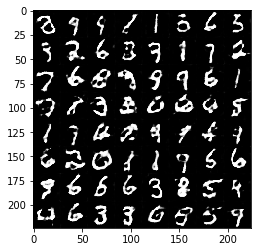

In [17]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('/content/results/mnist/GAN/GAN_epoch001.png')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)


plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

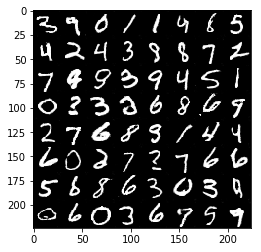

In [18]:
im = cv2.imread('/content/results/mnist/GAN/GAN_epoch050.png')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

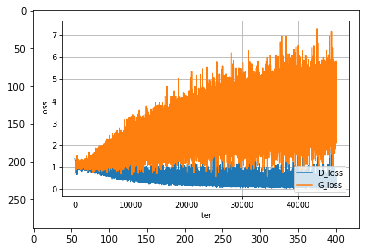

In [27]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/models/mnist/GAN/GAN_loss.png')
imgplot = plt.imshow(img)
plt.show()